In [1]:
import os, sys, csv, gzip
import numpy as np
import pandas as pd
import scipy.sparse as sp
from scipy import io

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 ## Output Type 3 (Type3) or Type 42 (TrueType)
rcParams['font.sans-serif'] = 'Arial'
%matplotlib inline
from plots import COLORS10, enlarge_tick_fontsize
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.cross_validation import (StratifiedKFold, cross_val_score)
from sklearn.metrics import *
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble
from sklearn.pipeline import Pipeline
import xgboost as xgb

import requests
# from harmonizomeapi import HarmonizomeAPI, Entity # http://amp.pharm.mssm.edu/Harmonizome/documentation

# Temporary, Output Filepaths
data_root, out_root = '../data/', '../'

# 1. Prepare the gene/feature attribute matrices and target class to for supervised machine learning

Load known Adhesome components from file

In [2]:
df_labels = pd.read_csv(requests.get('http://adhesome.org/components.csv').content)
print df_labels.shape
df_labels.head()

(232, 7)


,Official Symbol,Gene ID,Protein name,Swiss-Prot ID,Synonyms,Functional Category,FA
0,ACTN1,87,Actinin,P12814,alpha-actinin,Actin regulation,Intrinsic Proteins
1,CFL1,1072,cofilin,P23528,CFL,Actin regulation,Intrinsic Proteins
2,CORO1B,57175,coronin 1B,Q9BR76,coronin-2,Actin regulation,Intrinsic Proteins
3,CTTN,2017,Cortactin,Q14247,"EMS1, Amplaxin",Actin regulation,Intrinsic Proteins
4,FLNA,2316,Filamin,P21333,"endothelial actin-binding protein, ABP-280, al...",Actin regulation,Intrinsic Proteins


These files below were downloaded from [Harmonizome](http://amp.pharm.mssm.edu/Harmonizome/) as the features for genes to predict whether they are adhesome components. 

There are two types datasets: continues and binary. Continues datasets were standardized.    

In [3]:
filenames = [
        'InterPro_gene_attribute_matrix.txt.gz', 
        'ENCODE-TF_gene_attribute_matrix.txt.gz',
        'CCLE-GE_gene_attribute_matrix_standardized.txt.gz',
        'Allen-adult-brain_gene_attribute_matrix_standardized.txt.gz',
        'Allen-dev-brain_gene_attribute_matrix_standardized.txt.gz'
    ]
# TODO
# datasets = [
#         'InterPro Predicted Protein Domain Annotations',
#         'ENCODE Transcription Factor Binding Site Profiles',
#         'CCLE Cell Line Gene Expression Profiles',
#         'Allen Brain Atlas Adult Human Brain Tissue Gene Expression Profiles',
#         'Allen Brain Atlas Developing Human Brain Tissue Gene Expression Profiles by Microarray',
#     ]
# filenames = []
# for dataset in datasets:
#     data = HarmonizomeAPI.get(Entity.DATASET, name=dataset,
#                               download='gene_attribute_matrix_standardized.txt.gz')
#     if data['response'] == '404':
#         data = HarmonizomeAPI.get(Entity.DATASET, name=dataset,
#                                   download='gene_attribute_matrix.txt.gz')
#         if data['response'] == '404':
#             continue
#     filenames.append(data['filename'])

basenames = [f.split('_')[0] for f in filenames]
are_continues = ['_standardized' in f for f in filenames]

In [4]:
def read_gene_attribute_matrix(fn):
    '''
    Reads a gzipped file downloaded from Harmonizome into a pandas.DataFrame,
    with GeneSym as index. 
    '''
    with gzip.open(fn) as f:
        reader = csv.reader(f, delimiter='\t')
        header = reader.next()
        header[0] = 'GeneSym'
        # Skip line 2, 3
        reader.next()
        reader.next()

        # Remove the second and third columns which are meta data for GeneSym
        header[1:3] = []

        i = 0
        df = []

        if '_standardized' in fn: # continues
            for row in reader:
                row[1:3] = []
                row[1:] = map(float, row[1:])
                df.append(dict(zip(header, row)))
                i += 1
                if i % 2000 == 0:
                    print i
            df = pd.DataFrame()\
                .from_records(df, index=['GeneSym'])\
                .to_sparse(fill_value=0)

        else: # convert values to int and make sparse df
            for row in reader:
                row[1:3] = []
                row[1:] = [int(float(d)) for d in row[1:]]
                df.append(dict(zip(header, row)))
                i += 1
                if i % 2000 == 0:
                    print i
            df = pd.DataFrame()\
                .from_records(df, index=['GeneSym'])\
                .to_sparse(fill_value=0)
        
    return df

In [5]:
## Parse data files downloaded from Harmonizome 
dfs = []
for fn in filenames:
    df = read_gene_attribute_matrix(data_root+fn)
    print fn, df.shape
    dfs.append(df)

2000
4000
6000
8000
10000
12000
14000
16000
18000
InterPro_gene_attribute_matrix.txt.gz (18002, 11015)
2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
ENCODE-TF_gene_attribute_matrix.txt.gz (22845, 1679)
2000
4000
6000
8000
10000
12000
14000
16000
18000
CCLE-GE_gene_attribute_matrix_standardized.txt.gz (18046, 1035)
2000
4000
6000
8000
10000
12000
14000
16000
Allen-adult-brain_gene_attribute_matrix_standardized.txt.gz (17979, 414)
2000
4000
6000
8000
10000
12000
14000
16000
Allen-dev-brain_gene_attribute_matrix_standardized.txt.gz (17241, 492)


In [6]:
## INNER JOIN all feature dfs 
df_joined = reduce(lambda a, b: pd.merge(a, b, left_index=True, right_index=True, how='inner'), 
           dfs)
print df_joined.shape

(13464, 14635)


In [7]:
## Create y 
RNG = 2016
y = np.in1d(df_joined.index, df_labels['Official Symbol']).astype(np.int8)
print y.sum()
## Make CV
cv = StratifiedKFold(y, n_folds=3, shuffle=True, random_state=RNG)
## Export y
df_labels = pd.DataFrame({'y': y, 'GeneSym': df_joined.index}).set_index('GeneSym')
print df_labels.shape
df_labels.to_csv(data_root+'Adhesome.csv')
df_labels.head()

216
(13464, 1)


,y
GeneSym,
NUSAP1,0
WEE1,0
BUB1B,0
ASPM,0
TTK,0


In [8]:
## Keep only the shared genes across the 4 datasets
dfs = [df.ix[df_joined.index] for df in dfs]

In [9]:
## Export processed matrices in dfs
feature_names = {} # To store feature names
i = 0
for basename, df in zip(basenames, dfs):
    feature_names[basename] = df.columns.tolist()
    if are_continues[i]:
        np.save(data_root+basename+'_shared', df.values)
    else: # sparse matrix
        io.mmwrite(data_root+basename+'_shared.mtx', sp.csr_matrix(df.values))
    i += 1

del df_joined
del dfs, df

# 2. Load preprocessed matrices and perform classifications

In [10]:
# Load from matrices files generated above
Xs = []
for i, basename in enumerate(basenames):
    if are_continues[i]:
        Xs.append(np.load(data_root+basename+'_shared.npy'))
    else:
        Xs.append(io.mmread(data_root+basename+'_shared.mtx').tocsr())

df_labels = pd.read_csv(data_root+'Adhesome.csv')
y = df_labels['y'].values
ratio = float(np.sum(y == 0)) / np.sum(y==1)
print 'Number of known adhesome components: %d' % y.sum()
print 'Ratio of negative labels over positive labels: %.4f' % ratio

Number of known adhesome components: 216
Ratio of negative labels over positive labels: 61.3333


Perform dimentionality reduction using `TruncatedSVD` for all the matrices

In [11]:
all_loadings = [] # collect loading matrices from SVD
for i, basename in enumerate(basenames):
    svd = TruncatedSVD(n_components=60, random_state=RNG)
    Xs[i] = svd.fit_transform(Xs[i])
    all_loadings.append(svd.components_)

X_combined = np.hstack(Xs)

In [12]:
## Helper functions for evaluating classifiers
def cross_val_predictions(est, X, y, cv):
    '''to get out-of-sample predictions and scores'''
    y_preds = np.zeros(y.shape)
    y_probas = np.zeros(y.shape)
    for train_idx, valid_idx in cv:
        print X[train_idx].shape, y[train_idx].shape
        est.fit(X[train_idx], y[train_idx])
        y_preds[valid_idx] = est.predict(X[valid_idx])
        y_probas[valid_idx] = est.predict_proba(X[valid_idx])[:,1]
    return y_preds, y_probas


def plot_roc(ests, Xs, y, cv, ax, colors=None, labels=None):
    all_labels = []
    total = len(labels)

    if type(ests) == list and type(Xs) != list:
        total = len(ests)
        Xs = [Xs]*total
    elif type(ests) != list and type(Xs) == list:
        ests = [ests]*total
    
    for i in range(total):
        X = Xs[i]
        est = ests[i]
        
        label = labels[i]
        color = colors[i]
        all_labels.extend([label] * len(cv))

        y_preds, y_probas = cross_val_predictions(est, X, y, cv)
        fpr, tpr, _ = roc_curve(y, y_probas)
        score = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=label + ' (AUC=%.3f)' % score, color=color, lw=2)

    ax.set_xlabel('False Positive Rate', fontsize=16)
    ax.set_ylabel('True Positive Rate', fontsize=16)

    enlarge_tick_fontsize(ax, 12)
    ax.legend(loc='lower right')
    return

Estimate the number of rounds of boosting using early stopping for a single feature matrix InterPro: The boosting classifier will stop if the validation score does not improve in 50 rounds.

In [13]:
dtrain = xgb.DMatrix(Xs[0], label=y)

param = {
    'max_depth':10, 'eta':0.05, 'silent':1, 'objective':'binary:logistic',
    'subsample': 0.4, 'colsample_bytree': 0.6,
    'min_child_weight': 50,
    'scale_pos_weight': ratio,
    'nthread': 6
}

num_round = 5000
scores = xgb.cv(param, dtrain, num_round, 
    folds=cv,
    early_stopping_rounds=50,
    metrics='auc', seed=RNG,
    verbose_eval=10)

print scores.tail()


[0]	train-auc:0.819078+0.00896913	test-auc:0.754716+0.0113372
[10]	train-auc:0.944182+0.00571151	test-auc:0.853252+0.0185019
[20]	train-auc:0.956034+0.00553511	test-auc:0.857527+0.0161496
[30]	train-auc:0.961759+0.00447018	test-auc:0.856757+0.0163623
[40]	train-auc:0.964968+0.00283139	test-auc:0.853945+0.0152583
[50]	train-auc:0.969493+0.00202225	test-auc:0.85548+0.0132331
[60]	train-auc:0.972495+0.00229561	test-auc:0.858163+0.0117549
[70]	train-auc:0.974844+0.00236331	test-auc:0.854632+0.0115489
    test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
19       0.858624      0.015774        0.955314       0.004711
20       0.857527      0.016150        0.956034       0.005535
21       0.858936      0.015842        0.956524       0.005947
22       0.860072      0.015355        0.957875       0.005476
23       0.860647      0.014478        0.958389       0.005377


Estimate the number of rounds of boosting using early stopping for the combined feature matrix.

In [14]:
dtrain = xgb.DMatrix(X_combined, label=y)

param = {
    'max_depth':12, 'eta':0.05, 'silent':1, 'objective':'binary:logistic',
    'subsample': 0.4, 'colsample_bytree': 0.4,
    'min_child_weight': 50,
    'scale_pos_weight': ratio,
    'nthread': 6
}

num_round = 5000
scores = xgb.cv(param, dtrain, num_round, 
    folds=cv,
    early_stopping_rounds=50,
    metrics='auc', seed=RNG,
    verbose_eval=10)

print scores.tail()


[0]	train-auc:0.792973+0.0248245	test-auc:0.653439+0.0498941
[10]	train-auc:0.967718+0.000744999	test-auc:0.837223+0.0115881
[20]	train-auc:0.982213+0.00231581	test-auc:0.854458+0.00781185
[30]	train-auc:0.989075+0.000723179	test-auc:0.860422+0.00706163
[40]	train-auc:0.992837+0.000238599	test-auc:0.861134+0.0106238
[50]	train-auc:0.995449+0.00031224	test-auc:0.865086+0.0112055
[60]	train-auc:0.996595+0.000288426	test-auc:0.864528+0.0104053
[70]	train-auc:0.997708+0.000243488	test-auc:0.866287+0.0090724
[80]	train-auc:0.998522+0.000146727	test-auc:0.867463+0.00936827
[90]	train-auc:0.999017+9.94027e-05	test-auc:0.865591+0.00889278
[100]	train-auc:0.999232+0.000113085	test-auc:0.867229+0.0093478
[110]	train-auc:0.999409+0.000123443	test-auc:0.866462+0.0106765
[120]	train-auc:0.999586+0.000137421	test-auc:0.866448+0.0101588
    test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
73       0.866663      0.009920        0.997974       0.000306
74       0.866215      0.009327        0

Plot the ROC curves to evaluate the predictive performance of the GBM classifiers

(8976, 60) (8976,)
(8976, 60) (8976,)
(8976, 60) (8976,)
(8976, 60) (8976,)
(8976, 60) (8976,)
(8976, 60) (8976,)
(8976, 60) (8976,)
(8976, 60) (8976,)
(8976, 60) (8976,)
(8976, 60) (8976,)
(8976, 60) (8976,)
(8976, 60) (8976,)
(8976, 60) (8976,)
(8976, 60) (8976,)
(8976, 60) (8976,)
(8976, 300) (8976,)
(8976, 300) (8976,)
(8976, 300) (8976,)


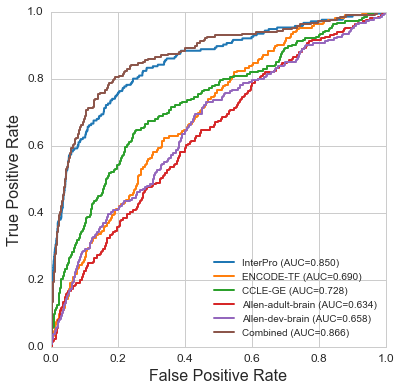

In [15]:
Xs.append(X_combined)
basenames.append('Combined')

# optimized GBM classifiers
xgbc = xgb.XGBClassifier(seed=RNG, n_estimators=39, learning_rate=0.05,
    max_depth=10, colsample_bytree=0.6, subsample=0.4, min_child_weight=50,
    gamma=0, max_delta_step=0, nthread=6, silent=True, scale_pos_weight=ratio)

xgbc2 = xgb.XGBClassifier(seed=RNG, n_estimators=159, learning_rate=0.05,
    max_depth=12, colsample_bytree=0.4, subsample=0.4, min_child_weight=50,
    gamma=0, max_delta_step=0, nthread=6, silent=True, scale_pos_weight=ratio)

clfs = [xgbc] * 5 + [xgbc2]

fig, ax = plt.subplots(figsize=(6,6))
plot_roc(clfs, Xs, y, cv, ax, colors=COLORS10, labels=basenames)

# 3. Apply the GBM classifier to all the datasets to generate predictions 

In [16]:
RNG = 20160628
xgbc2 = xgb.XGBClassifier(seed=RNG, n_estimators=160, learning_rate=0.05,
    max_depth=12, colsample_bytree=0.4, subsample=0.4, min_child_weight=50,
    gamma=0, max_delta_step=0, nthread=8, silent=True, scale_pos_weight=ratio)

cv = StratifiedKFold(y, n_folds=10, shuffle=True, random_state=RNG)

## Get out-of-fold predictions
y_preds, y_probas = cross_val_predictions(xgbc2, X_combined, y, cv)

## Get predictions on training fold
xgbc2.fit(X_combined, y)
y_probas_on_train = xgbc2.predict_proba(X_combined)[:, 1]


(12117, 300) (12117,)
(12117, 300) (12117,)
(12117, 300) (12117,)
(12117, 300) (12117,)
(12117, 300) (12117,)
(12117, 300) (12117,)
(12118, 300) (12118,)
(12118, 300) (12118,)
(12119, 300) (12119,)
(12119, 300) (12119,)


In [17]:
df_labels['OOF_preds'] = y_preds
df_labels['OOF_probas'] = y_probas
df_labels['train_probas'] = y_probas_on_train

df_labels.head()

,GeneSym,y,OOF_preds,OOF_probas,train_probas
0,NUSAP1,0,0.0,0.048701,0.012676
1,WEE1,0,0.0,0.047994,0.040922
2,BUB1B,0,0.0,0.012071,0.021857
3,ASPM,0,0.0,0.073338,0.024251
4,TTK,0,0.0,0.064439,0.020047


In [18]:
df_labels.to_csv(out_root+'XGB160_on_combined_predictions.csv')

# 4. Intepret the classifier by feature importances

In [19]:
## Get the feature_importances_ from the fitted GBM
feature_importances = xgbc2.feature_importances_
print feature_importances.shape

(300,)


In [20]:
## Count the number of original features
n_features = sum(map(len, feature_names.values()))
print 'There are %d features across these datasets used for the prediction' % n_features

There are 14635 features across these datasets used for the prediction


Map feature importances on the SVD components back to original feature space by dot product between the feature importance vector and the loading matrix:

In [21]:
all_feature_names = []
all_feature_fis = []
datasets = []
for i, basename in enumerate(basenames[:-1]):
    fi = feature_importances[i*60:(i+1)*60]
    loadings = all_loadings[i]
    original_feature_fis = np.dot(fi, loadings)
    original_feature_names = feature_names[basename]
    
    datasets.extend([basename] * len(original_feature_names))
    all_feature_fis.extend( original_feature_fis.tolist() )
    all_feature_names.extend( original_feature_names )

# Create a DataFrame of feature importances
df_feature_importances = pd.DataFrame({
        'dataset': datasets,
        'feature': all_feature_names, 
        'feature_importance': all_feature_fis})    

Examine the most predictive features for adhesome components:

In [22]:
df_feature_importances.sort('feature_importance', ascending=False).head(20)

/Users/maayanlab/.pyenv/versions/2.7.11/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,dataset,feature,feature_importance
875,InterPro,Armadillo-type fold,0.010381
4473,InterPro,Immunoglobulin-like fold,0.007555
7372,InterPro,Protein kinase-like domain,0.007074
3362,InterPro,Fibronectin type III,0.006753
874,InterPro,Armadillo-like helical,0.006399
13746,Allen-adult-brain,"Edinger-Westphal nucleus, right",0.006343
7369,InterPro,Protein kinase domain,0.006104
2466,InterPro,Death-like domain,0.005935
10351,InterPro,Ubiquitin-related domain,0.005866
6930,InterPro,Pleckstrin homology-like domain,0.005526


In [23]:
df_feature_importances.to_csv(out_root+'feature_importances.csv')